In [1]:
import pandas

In [2]:
import root_numpy

In [3]:
x = pandas.read_csv('../data/global_test.csv')

In [4]:
x = x.drop(['Unnamed: 0'], axis=1)

In [5]:
root_numpy.array2root(x.to_records(index=False), "../data/global_test.root", mode='recreate')

In [6]:
x = root_numpy.root2array("../data/global_test.root")

In [7]:
import pandas
x = pandas.DataFrame(x)

In [8]:
from collections import Counter
Counter(abs(x.MCParticleType.values))

Counter({0: 999998,
         11: 999999,
         13: 999996,
         211: 999998,
         321: 999997,
         2212: 1000002})

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy

## Read the data

In [3]:
data_big = pandas.DataFrame(root_numpy.root2array('../data/data_million_of_each_class_filtered.root', 'tree'))

In [4]:
data_small = pandas.concat([pandas.read_csv('../data/data_train_Long.csv'),
                            pandas.read_csv('../data/data_eval_Long.csv')])

#### add signal column (from 0 to 5 classes), weights (to balance data), charges (to check assymetry)

In [5]:
from utils import compute_labels_and_weights, compute_charges, names_labels_correspondence, labels_names_correspondence
from utils import plot_hist_features, roc_auc_score_one_vs_all, compute_cum_sum, convert_DLL_to_LL

In [6]:
data_big['Signal'], data_big['Weight'] = compute_labels_and_weights(data_big.MCParticleType.values)
data_small['Signal'], data_small['Weight'] = compute_labels_and_weights(data_small.MCParticleType.values)

# Train, test splitting

In [7]:
from sklearn.cross_validation import train_test_split
data_big_train, data_big_test = train_test_split(data_big, train_size=0.5, random_state=19)
data_small_train, data_small_test = train_test_split(data_small, train_size=0.5, random_state=19)

In [43]:
for i in range(6):
    print labels_names_correspondence[i]
    print '\t File 1: %1.5f ' % (sum(data_big_train['Signal'] == i) * 100. / len(data_big_train)),
    print '\t File 2: %1.5f ' % (sum(data_small_train['Signal'] == i) * 100. / len(data_small_train))
    print '\t File 1: %d' % sum(data_big_train['Signal'] == i),
    print '\t File 2: %d' % sum(data_small_train['Signal'] == i)

Ghost
	 File 1: 17.85127  	 File 2: 14.18909 
	 File 1: 535538 	 File 2: 156080
Electron
	 File 1: 15.48843  	 File 2: 0.49164 
	 File 1: 464653 	 File 2: 5408
Muon
	 File 1: 16.67320  	 File 2: 3.24764 
	 File 1: 500196 	 File 2: 35724
Pion
	 File 1: 16.66963  	 File 2: 64.25100 
	 File 1: 500089 	 File 2: 706761
Kaon
	 File 1: 16.65270  	 File 2: 11.08218 
	 File 1: 499581 	 File 2: 121904
Proton
	 File 1: 16.66477  	 File 2: 6.73845 
	 File 1: 499943 	 File 2: 74123


# Compare features

In [44]:
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.metrics import roc_auc_score

def compare_data(data1, data2, weights1, weights2, features, ignored_sideband=0.05, particle=""):
    kw = {'bins': 60, 'alpha': 0.3, 'normed': True}
    k = int(numpy.ceil(len(features) / 3.))
    for n, f in enumerate(features):
        plt.subplot(k, 3, n + 1)
        val = data1[f].values
        v_min, v_max = numpy.percentile(val[val != -999], [ignored_sideband * 100, (1. - ignored_sideband) * 100])
        plt.hist(data1[f].values, weights=weights1, range=(v_min, v_max), **kw)
        plt.hist(data2[f].values, weights=weights2, range=(v_min, v_max), **kw)
        plt.title('%s: KS=%1.5f, AUC=%1.5f' % (particle, 
                                       ks_2samp_weighted(data1[f].values, data2[f].values, 
                                                         weights1, weights2),
                                       roc_auc_score([0] * len(data1) + [1] * len(data2),
                                                     numpy.concatenate([data1[f].values, data2[f].values]), 
                                                    sample_weight=numpy.concatenate([weights1, weights2])))
                 )
        plt.xlabel(f)

In [9]:
features_acceptance = ['InAccSpd', 'InAccPrs', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon']

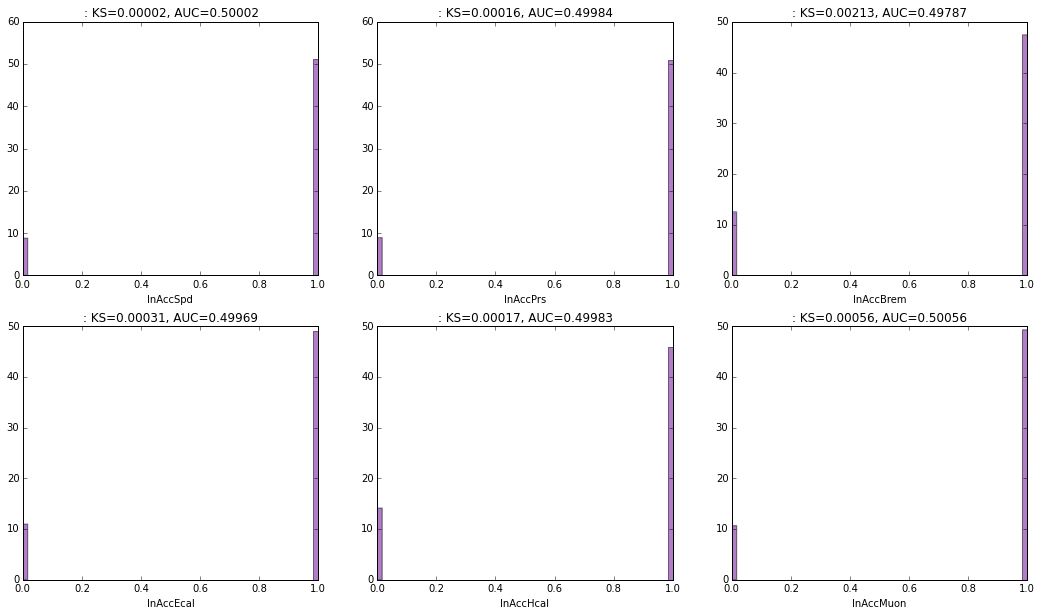

In [45]:
figure(figsize=(18, 10))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_acceptance)

In [12]:
features_CALO_DLL_e = ['PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe']
features_CALO_DLL_mu  = ['EcalPIDmu', 'HcalPIDmu']
features_CALO_E = ['CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE']
features_CALO_neutral  = ['CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal']
features_CALO_charged = ['CaloChargedSpd', 'CaloChargedPrs' , 'CaloChargedEcal']
features_CALO_others = ['CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL']
features_CALO = features_CALO_others + features_CALO_charged + features_CALO_neutral + features_CALO_E + \
    features_CALO_DLL_mu + features_CALO_DLL_e

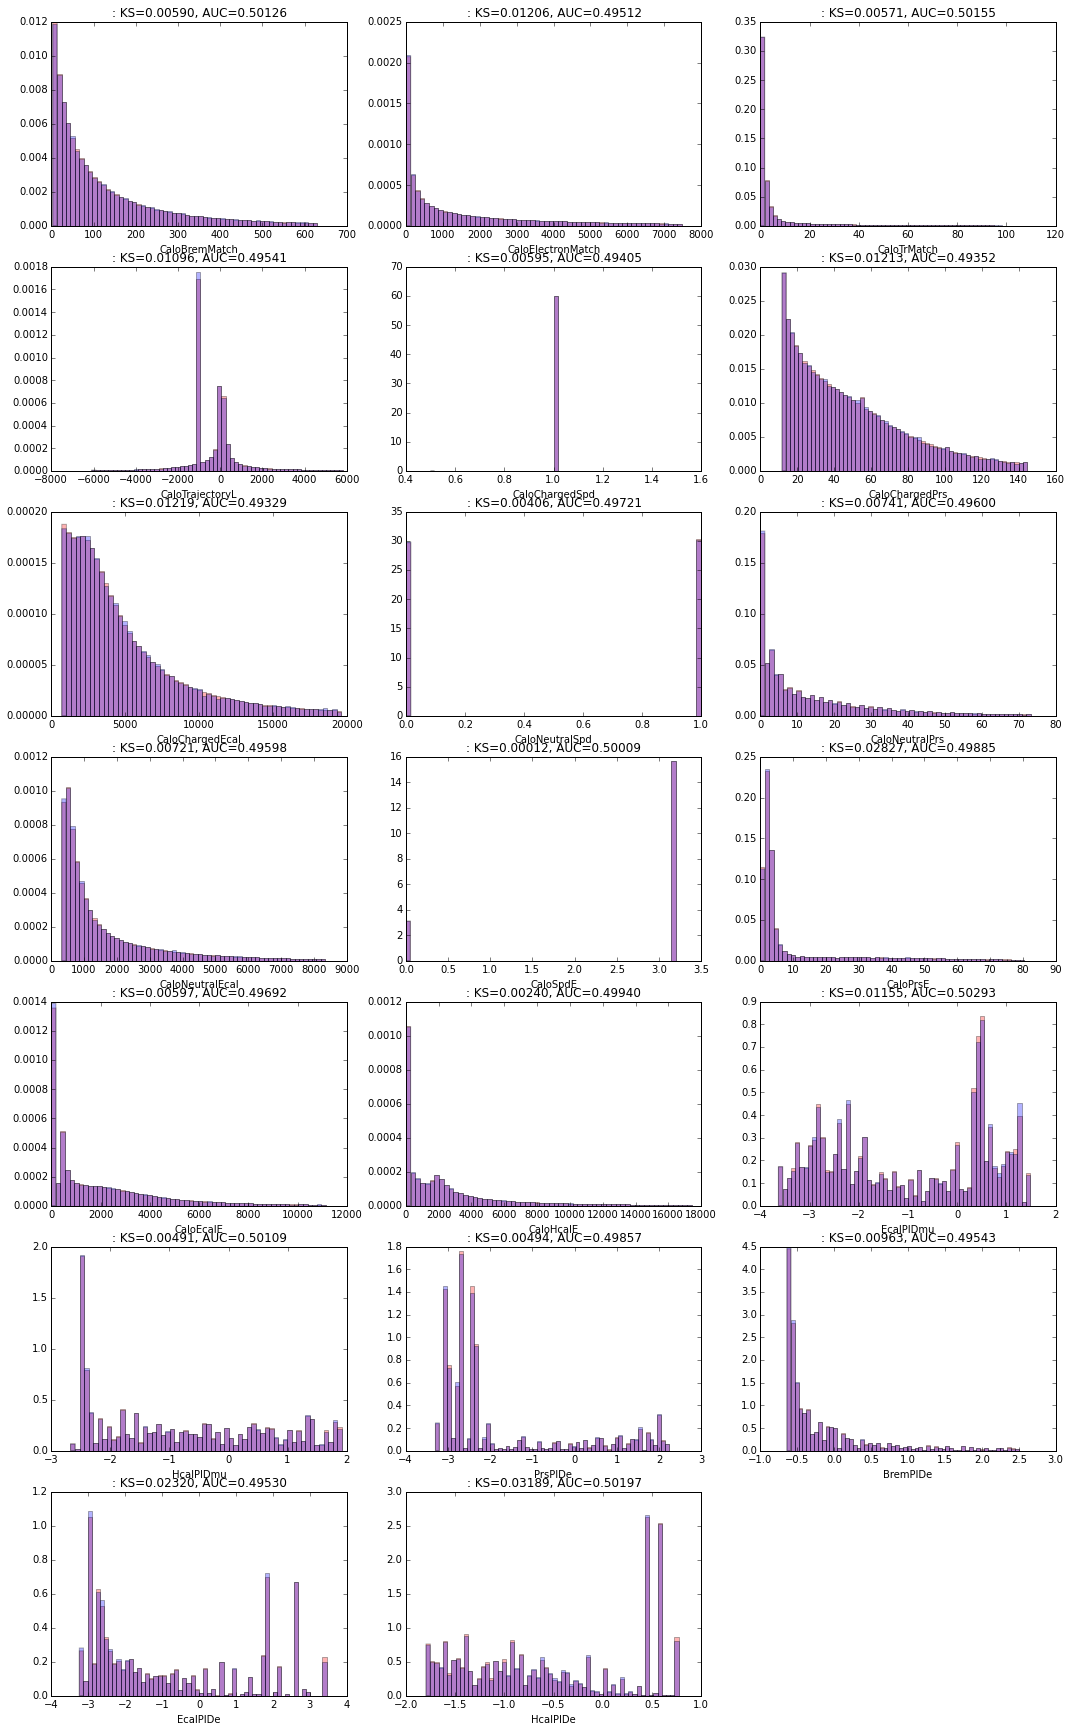

In [46]:
figure(figsize=(18, 30))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_CALO)

In [14]:
features_RICH_DLL = filter(lambda x: 'RichDLL' in x, data_big.columns)
features_RICH_gas = ['RichUsedR1Gas', 'RichUsedR2Gas']
features_RICH_above = filter(lambda x: 'RichAbove' in x, data_big.columns)
features_RICH = features_RICH_above + features_RICH_gas + features_RICH_DLL

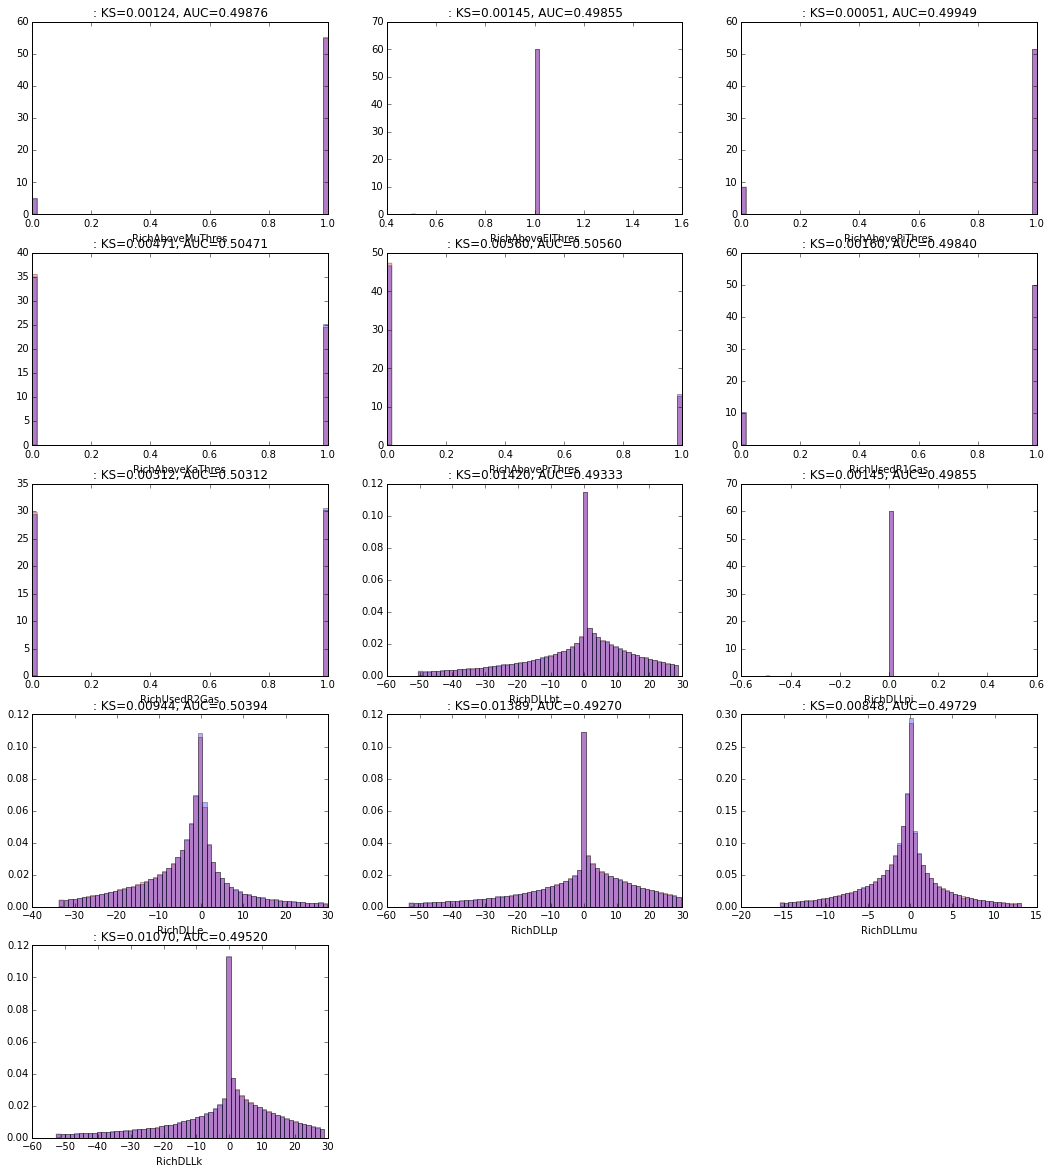

In [47]:
figure(figsize=(18, 20))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_RICH)

In [16]:
features_Comb_DLL = filter(lambda x: 'CombDLL' in x, data_big.columns)

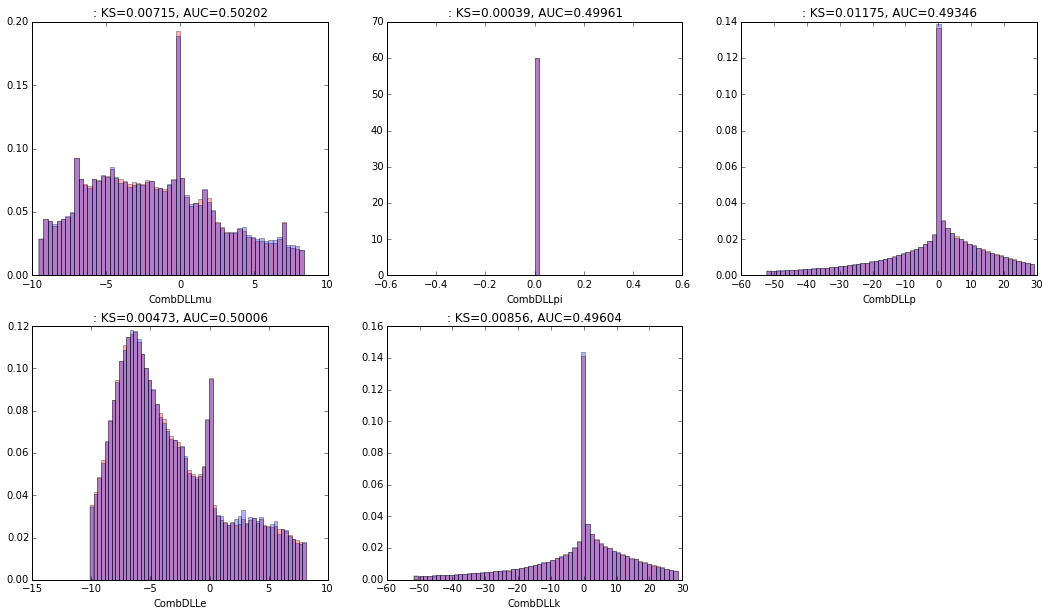

In [48]:
figure(figsize=(18, 10))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_Comb_DLL)

In [22]:
features_track = filter(lambda x: 'Track' in x, data_big.columns) 
features_track = list(set(features_track) - {'TrackMatchChi2', 'TrackCloneDist', 'TrackType', 'TrackLikelihood',
                                            'NumMuonTracks', 'NumDownstreamTracks', 'NumLongTracks', 'NumVeloTracks',
                                            'NumUpstreamTracks', 'NumTTracks', 'TrackHistory',})

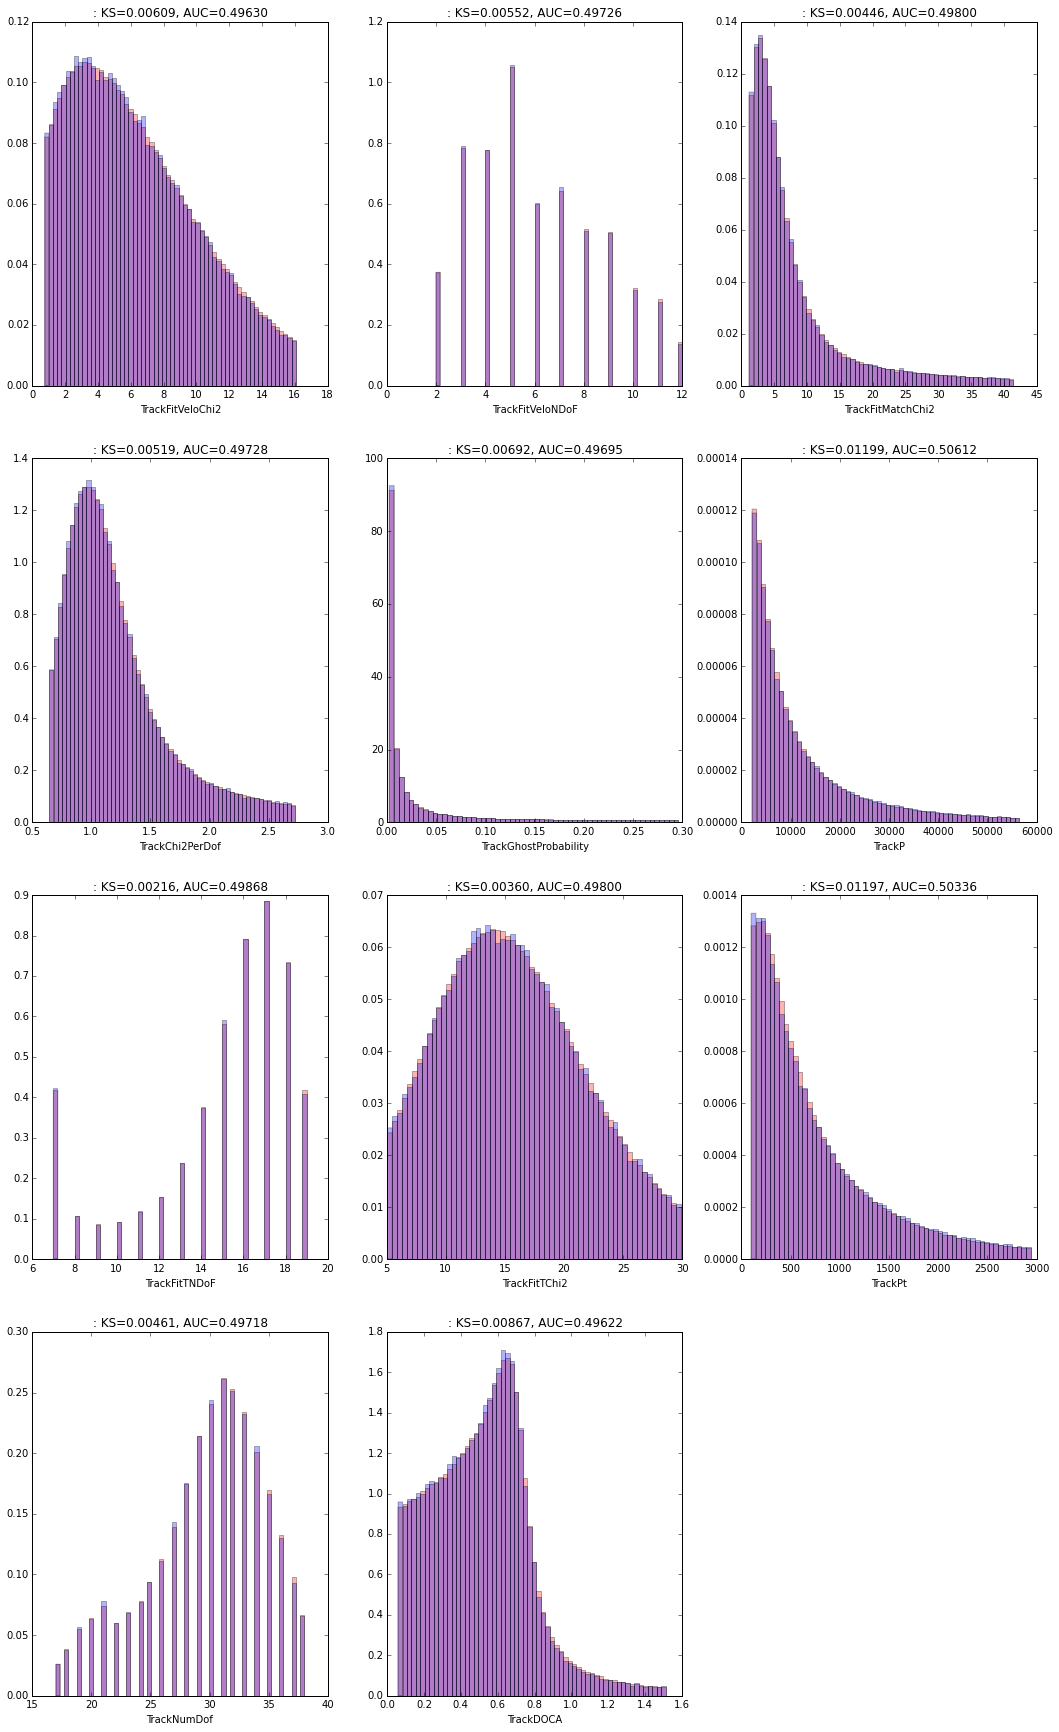

In [49]:
figure(figsize=(18, 30))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_track)

In [24]:
features_muon = ['MuonNShared', 'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'MuonMuLL'] 

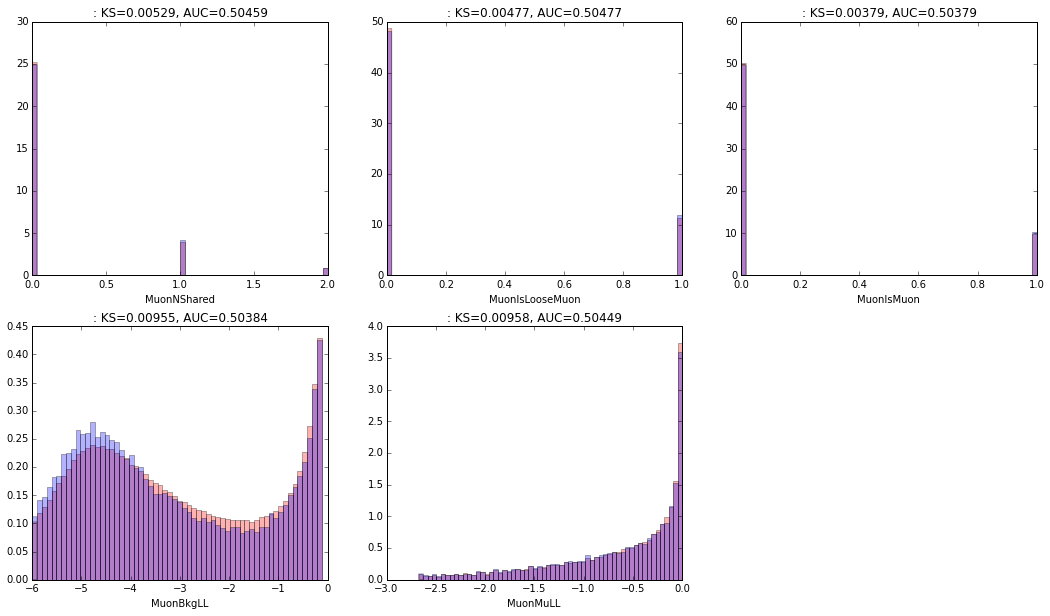

In [50]:
figure(figsize=(18, 10))
compare_data(data_big_train, data_small_train, data_big_train.Weight.values, data_small_train.Weight.values, features_muon)

In [26]:
features_original = features_acceptance + features_CALO + features_RICH + features_Comb_DLL + features_track + features_muon

In [27]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

# DT for each particle

In [35]:
dt_particles = {}
for i in range(6):
    dt_p = SklearnClassifier(DecisionTrainClassifier(n_estimators=1000, depth=6, learning_rate=0.1, n_threads=12), 
                             features=features_original)
    dt_p.fit(pandas.concat([data_big_train[data_big_train.Signal == i], 
                            data_small_train[data_small_train.Signal == i]]), 
             [0] * sum(data_big_train.Signal == i) + [1] * sum(data_small_train.Signal == i))
    dt_particles[i] = dt_p
    print i, 

0 1 2 3 4 5


## on train

In [36]:
for i in range(6):
    p1 = dt_particles[i].predict_proba(data_big_train[data_big_train.Signal == i])[:, 1]
    p2 = dt_particles[i].predict_proba(data_small_train[data_small_train.Signal == i])[:, 1]
    print labels_names_correspondence[i],
    print roc_auc_score([0] * sum(data_big_train.Signal == i) + [1] * sum(data_small_train.Signal == i),
                         numpy.concatenate([p1, p2]))

Ghost 0.574274516066
Electron 0.578130582521
Muon 0.606397738901
Pion 0.543287160783
Kaon 0.569302061576
Proton 0.576934375216


## on test

In [37]:
for i in range(6):
    p1 = dt_particles[i].predict_proba(data_big_test[data_big_test.Signal == i])[:, 1]
    p2 = dt_particles[i].predict_proba(data_small_test[data_small_test.Signal == i])[:, 1]
    print labels_names_correspondence[i],
    print roc_auc_score([0] * sum(data_big_test.Signal == i) + [1] * sum(data_small_test.Signal == i),
                         numpy.concatenate([p1, p2]))

Ghost 0.523808255608
Electron 0.524896015012
Muon 0.585256217896
Pion 0.499497412709
Kaon 0.511322669281
Proton 0.510215097514


In [38]:
reports = {}
for i in range(6):
    reports[i] = dt_particles[i].test_on(pandas.concat([data_big_test[data_big_test.Signal == i],
                                                       data_small_test[data_small_test.Signal == i]]), 
                                         [0] * sum(data_big_test.Signal == i) + [1] * sum(data_small_test.Signal == i))

In [41]:
from rep.report.metrics import RocAuc
lc = []
for i in range(6):
    lc.append(reports[i].learning_curve(RocAuc(), steps=1))

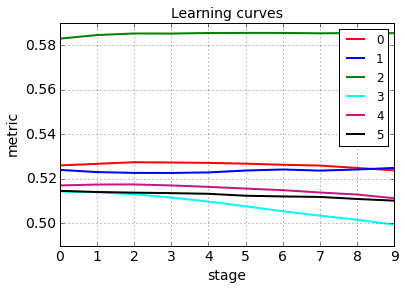

In [42]:
for l in lc:
    l.plot(show_legend=False)
legend(range(6))